**Author:** Beatrice Occhiena s314971. See [`LICENSE`](https://github.com/beatrice-occhiena/Computational_intelligence/blob/main/LICENSE) for details.
- institutional email: `S314971@studenti.polito.it`
- personal email: `beatrice.occhiena@live.it`
- github repository: [https://github.com/beatrice-occhiena/Computational_intelligence.git](https://github.com/beatrice-occhiena/Computational_intelligence.git)

**Resources:** These notes are the result of additional research and analysis of the lecture material presented by Professor Giovanni Squillero for the Computational Intelligence course during the academic year 2023-2024 @ Politecnico di Torino. They are intended to be my attempt to make a personal contribution and to rework the topics covered in the following resources.
- [https://github.com/squillero/computational-intelligence](https://github.com/squillero/computational-intelligence)
- Stuart Russel, Peter Norvig, *Artificial Intelligence: A Modern Approach* [3th edition]
- Richard S. Sutton, Andrew G. Barto, *Reinforcement Learning: An Introduction* [2nd Edition]

.

.

# Lab 10: Reinforcement Learning
Use reinforcement learning to devise a tic-tac-toe player. 

In [70]:
from itertools import combinations
from collections import namedtuple, defaultdict
from random import choice
from copy import deepcopy

from tqdm.auto import tqdm
import numpy as np

## Game Class

In [71]:
class TicTacToe:
  def __init__(self, starting_player='X'):
    # Initialize the empty board
    self.board = [[' ' for _ in range(3)] for _ in range(3)]
    # Define magic square to check for a winner
    self.magic_square = [[2, 7, 6], [9, 5, 1], [4, 3, 8]]
    # Define player symbols
    self.players = ['X', 'O']
    # Initialize the current player
    self.current_player = starting_player

  def print_board(self):
    """Display the current state of the board"""
    emoji_map = {'X': '❌', 'O': '🔘', ' ': '⬜'}
    for row in self.board:
      print(''.join([emoji_map[space] for space in row]))
    print()

  def make_move(self, row, col):
    """Make a move on the board if the space is empty"""
    if self.board[row][col] == ' ' and 0 <= row <= 2 and 0 <= col <= 2:
      self.board[row][col] = self.current_player
      return True # Move was successful
    else:
      print("Invalid move!")
      return False # Move was unsuccessful
    
  def switch_player(self):
    """Switch the current player"""
    self.current_player = self.players[(self.players.index(self.current_player) + 1) % 2]

  def check_winner(self):
    """
    Check if there is a winner on the board.
    - Returns 'X' if X wins
    - Returns 'O' if O wins
    - Returns None if there is no winner
    """
    # 1. Convert board positions to magic square values
    x_positions = [self.magic_square[row][col] for row in range(3) for col in range(3) if self.board[row][col] == 'X']
    o_positions = [self.magic_square[row][col] for row in range(3) for col in range(3) if self.board[row][col] == 'O']
    
    # 2. Check if any combination of 3 positions sums to 15
    if any(sum(comb) == 15 for comb in combinations(x_positions, 3)):
      return 'X'
    elif any(sum(comb) == 15 for comb in combinations(o_positions, 3)):
      return 'O'

    return None
  
  def is_draw(self):
    """Check if the game is a draw"""
    return all([space != ' ' for row in self.board for space in row])

## Player Class

In [72]:
class Player:
  def __init__(self):
    pass

  def make_move(self, game: TicTacToe):
    """Make a move in the given TicTacToe game instance"""
    raise NotImplementedError("This method should be implemented by subclasses.")

In [73]:
class HumanPlayer(Player):
  
  def make_move(self, game: TicTacToe):
    """Get a move from the user"""

    # 1. Print the board
    print("Current board:")
    game.print_board()

    # 2. Get a valid move from the user
    valid_move = False
    while not valid_move:
      try:
        row = int(input("Enter row (0-2): "))
        col = int(input("Enter column (0-2): "))
        valid_move = game.make_move(row, col)
        if not valid_move:
          print("Invalid move, try again.")
      except ValueError:
        print("Invalid input. Please enter numbers only.")

In [74]:
class RandomPlayer(Player):
    
  def make_move(self, game: TicTacToe):
    """Make a random move on the board"""
    # 1. Get all empty spaces
    empty_spaces = [(row, col) for row in range(3) for col in range(3) if game.board[row][col] == ' ']
    # 2. Choose a random empty space
    row, col = choice(empty_spaces)
    # 3. Make the move
    game.make_move(row, col)

## Match Implementation

In [75]:
def play_game(game: TicTacToe, player1: Player, player2: Player, verbose=False) -> str:
  
  """
    Play a game of TicTacToe between two players
    - player1 as 'X': The first player to make a move
    - player2 as 'O': The second player to make a move
    
    Returns the winner of the game
  """
  
  # 1. Initialize the game
  game_over = False
  winner = None

  # 2. Play the game
  while not game_over:
    # 2.1. Get the current player
    current_player = player1 if game.current_player == 'X' else player2

    # 2.2. VERBOSE: Print the board
    if verbose:
      print(f"Current player: {game.current_player}")
      game.print_board()

    # 2.3. Make a move
    current_player.make_move(game)

    # 2.4. Check if the game is over
    winner = game.check_winner()
    if winner is not None:
      game_over = True
    elif game.is_draw():
      game_over = True

    # 2.5. Switch the player
    game.switch_player()

  # 3. VERBOSE: Print the final board
  if verbose:
    print("Final board:")
    game.print_board()

  # 4. VERBOSE: Print the winner
  if winner is None:
    if verbose:
      print("It's a draw!")
    return 'draw'
  else:
    if verbose:
      print(f"{winner} wins!")
    return winner

In [76]:
def collect_results(player1: Player, player2: Player, n_games=1000, verbose=False):
  """
    Play n_games of TicTacToe between two players and return the results
    - player1 as 'X': The first player to make a move
    - player2 as 'O': The second player to make a move
  """
  # 1. Initialize the results
  results = defaultdict(int)

  # 2. Play the games
  # tqdm is a progress bar that displays the progress of the loop
  for _ in tqdm(range(n_games)):
    new_game = TicTacToe()
    winner = play_game(new_game, deepcopy(player1), deepcopy(player2), verbose=verbose)
    results[winner] += 1

  # 3. Print the results
  print(f"Player 1 ({player1.__class__.__name__}) wins: {results['X']}")
  print(f"Player 2 ({player2.__class__.__name__}) wins: {results['O']}")
  print(f"Draws: {results['draw']}")

  return results

### Example matches
Here are some examples of matches between two random players to show how the game works.

Current player: X
⬜⬜⬜
⬜⬜⬜
⬜⬜⬜

Current player: O
⬜❌⬜
⬜⬜⬜
⬜⬜⬜

Current player: X
🔘❌⬜
⬜⬜⬜
⬜⬜⬜

Current player: O
🔘❌⬜
⬜⬜⬜
❌⬜⬜

Current player: X
🔘❌⬜
⬜🔘⬜
❌⬜⬜

Current player: O
🔘❌⬜
⬜🔘❌
❌⬜⬜

Current player: X
🔘❌⬜
⬜🔘❌
❌🔘⬜

Current player: O
🔘❌❌
⬜🔘❌
❌🔘⬜

Final board:
🔘❌❌
⬜🔘❌
❌🔘🔘

O wins!


100%|██████████| 1000/1000 [00:00<00:00, 11425.66it/s]

Player 1 (RandomPlayer) wins: 574
Player 2 (RandomPlayer) wins: 305
Draws: 121


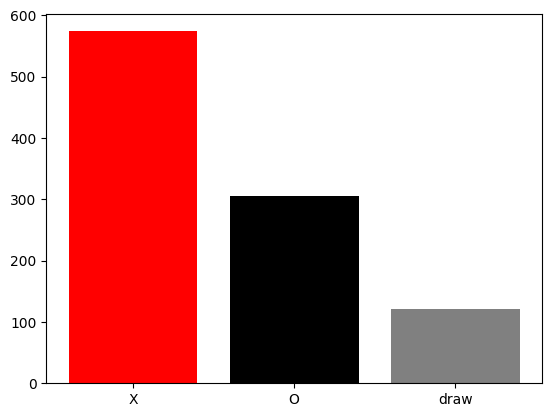

In [77]:
# 1. Initialize the players
rand_player1 = RandomPlayer()
rand_player2 = RandomPlayer()

# 2. Play one game with verbose output
new_game = TicTacToe()
play_game(new_game, rand_player1, rand_player2, verbose=True)

# 3. Play multiple games to collect the statistics
results = collect_results(rand_player1, rand_player2, n_games=1000, verbose=False)

# 4. Plot the results
import matplotlib.pyplot as plt
plt.bar(results.keys(), results.values(), color=['red', 'black', 'gray'])
plt.show()